In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [9]:
glob.glob('results_*.csv')

['results_1000.csv']

In [10]:
# all in nanoseconds
df = pd.concat([pd.read_csv(i) for i in glob.glob('results_*.csv')])

In [15]:
df = df.rename(columns=lambda x: x.strip())

In [16]:
df['Preprocessed Speedup'] = df.Classic / df.Preprocessed

df['General GPU Speedup'] = df.Classic / df['GPU General']
df['Reordered Memory General GPU Speedup'] = df.Classic / df['GPU reordered memory general']

df['Unrolled GPU Speedup'] = df.Classic / df['GPU JIT']
df['Reordered Memory General Unrolled GPU Speedup'] = df.Classic / df['GPU reordered memory JIT']

In [24]:
speedup_cols = ['Preprocessed Speedup','General GPU Speedup', 'Reordered Memory General GPU Speedup','Unrolled GPU Speedup','Reordered Memory General Unrolled GPU Speedup']

In [25]:
colors = ['#377eb8', '#ff7f00', '#4daf4a',
              '#f781bf', '#a65628', '#984ea3',
              '#999999', '#e41a1c', '#dede00']

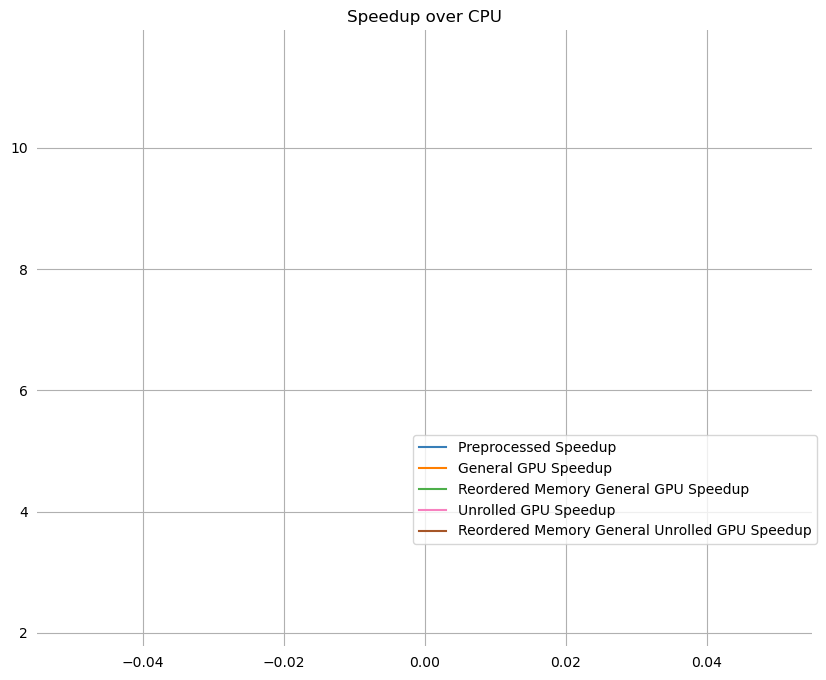

In [35]:
fig, ax = plt.subplots(figsize=(10,8))

df[speedup_cols].plot(ax=ax, color = colors, legend=False)

ax.spines[:].set_visible(False)
ax.grid()
ax.tick_params(width=0, which='both')
ax.set_title('Speedup over CPU')

fig.legend(loc = (0.5, 0.2));